In [14]:
from IPython.core.display import HTML
css_file = '../../../../msc/custom.css' 
HTML(open(css_file, 'r').read()) 

# GRMPY Package


In [20]:
# standard library
import os
import sys
import numpy as np

# edit PYTHONPATH
sys.path.insert(0, 'grmpy')

# project library
import grmpy as gp

Let us take a look at around the directory structure and files of the *grmpy* package in *PyCharm*. 

Now that we have an idea about the structure of the package, let us make some simple calls to the functions

In [21]:
# Process initialization file
init_dict = gp.process('init.ini')

# Simulate synthetic sample
gp.simulate(init_dict)

# Estimate model
rslt = gp.estimate(init_dict)

# Write results
gp.inspect(rslt, init_dict)

# Inspect the results
%cat results.txt


 softEcon: Generalized Roy Model
 -------------------------------

 Average Treatment Effects

     ATE       -0.41

     TT        -1.69

     TUT        0.87


 Parameters

     Start    Finish

      0.34      0.34
      0.55      0.55
      0.58      0.58
      0.52      0.52
      0.00      0.00
      0.99      0.99
      0.91      0.91
      0.21      0.21
      0.29      0.29
      0.52      0.52
      0.90      0.90
      0.98      0.98
      0.26      0.26
      0.06      0.06
      0.31      0.31


There are several implementations of the likelihood function available: fast, slow object. You can select the implementation to use in the initialization file. Let us make sure that the result is the same regardless of the implementation. 

In [22]:
# project library
from tests._auxiliary import random_init


NUM_TESTS = 1

for _ in range(NUM_TESTS):

    # Generate random request
    init_dict = random_init()

    # Ensure same starting value. If we choose the random 
    # starting values instead, the points of evaluation 
    # differ for the slow and fast implementations.
    init_dict['ESTIMATION']['start'] = 'init'

    # Simulate sample
    gp.simulate(init_dict)

    # Estimate generalize Roy model
    rslt = dict()

    for version in ['slow', 'fast']:

        init_dict['ESTIMATION']['version'] = version

        rslt[version] = gp.estimate(init_dict)['fval']

    # Assert equality of results
    np.testing.assert_allclose(rslt['slow'], rslt['fast'])

    # Cleanup
    os.remove(init_dict['BASICS']['file'])

Let's see how the execution time differes as we increase the number of observations.

In [36]:
# standard library
import time

# Set grid for varying number of agents
agent_grid = range(1000, 10000, 500)

# Generate random request
init_dict = random_init()

# Simulate sample
rslt = dict()

for version in ['slow', 'fast']:
    
    # Initialzie container for results
    rslt[version] = []
    
    # Update initialization file
    init_dict['ESTIMATION']['version'] = version
    
    for agents in agent_grid:
        
        # Update initialization file
        init_dict['BASICS']['agents'] = agents
        
        # Simulate sample
        gp.simulate(init_dict)
        
        # Measure execution time of request
        start_time = time.time()

        gp.estimate(init_dict)

        rslt[version] += [ time.time() - start_time]

Now we can easily visualize the difference in performance.

Populating the interactive namespace from numpy and matplotlib


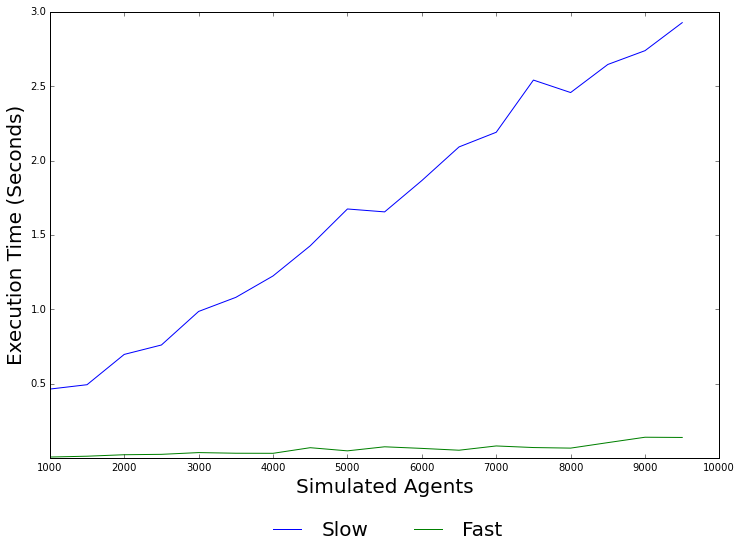

In [47]:
# standard library
import matplotlib.pyplot as plt

# Inline rendering of matplotlib graphs
%pylab inline

# Initialize canvas
ax = plt.figure(figsize=(12,8)).add_subplot(111)

# Plot execution times by implementations 
ax.plot(agent_grid, rslt['slow'], label = 'Slow')
ax.plot(agent_grid, rslt['fast'], label = 'Fast')

# Set axis labels
ax.set_xlabel('Simulated Agents', fontsize=20)
ax.set_ylabel('Execution Time (Seconds)', fontsize=20)

# Set up legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
    fancybox=False, frameon=False, shadow=False, ncol=2,
    fontsize=20)
     
# Remove first element on y-axis
ax.yaxis.get_major_ticks()[0].set_visible(False)

Now, let us finally have a look whether the program actually recovers the true structural parameters.

In [5]:
# Process initialization file
init_dict = gp.process('init.ini')

# Simulate synthetic sample
gp.simulate(init_dict)

# Estimate model
rslt = gp.estimate(init_dict)

# Write results
gp.inspect(rslt, init_dict)

# Inspect the results
%cat results.txt


 softEcon: Generalized Roy Model
 -------------------------------

 Average Treatment Effects

     ATE       -0.41

     TT        -1.69

     TUT        0.87


 Parameters

     Start    Finish

      0.34      0.34
      0.55      0.55
      0.58      0.58
      0.52      0.52
      0.00      0.00
      0.99      0.99
      0.91      0.91
      0.21      0.21
      0.29      0.29
      0.52      0.52
      0.90      0.90
      0.98      0.98
      0.26      0.26
      0.06      0.06
      0.31      0.31


How does this compare to the structural parameters we used for the simulation of the dataset?

In [12]:
%cat init.ini

BASICS

	agents   10
	file     dataset.txt

TREATED

	int  	0.5
	coeff  0.2
	coeff  0.52
	coeff  0.52

	var 	0.02

UNTREATED

	int  	0.1
	coeff 0.2
	coeff 0.3
  	coeff  0.52

	var 	0.02

COST

	coeff  0.125
	coeff  0.25
	coeff  0.35
	var    0.02

RHO
	
	treated  	0.12
	untreated   0.1

ESTIMATION

    optimizer bfgs
    start     random
    maxiter   0
    version   fast


That looks encouraging, but note that the specified data generating process has only small unobserved variation. We set $\sigma^2_{U_1} = \sigma^2_{V_1}= \sigma^2_{V_1} = 0.02$ and the performance of the estimator will deteriorate as we increase this variation. 